In [1]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm, colors
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append('/home/563/rl5183/Documents/CSIRO')
import categorical_enso_functions as func
from dask.distributed import wait
from scipy.stats import pearsonr
import xesmf
import cf_xarray
import seaborn as sns

In [2]:
# Launch Dask client 
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1)#(memory_limit=None, n_cpus=15≈1)
client.cluster.scale(8) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46255,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35627,Total threads: 1
Dashboard: /proxy/41245/status,Memory: 0 B
Nanny: tcp://127.0.0.1:40693,


2025-04-02 12:51:26,650 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 35c2d1d62f5590cfcbd9a01fd0f9562b initialized by task ('rechunk-merge-rechunk-transfer-a7ad8d8d9f986254a94ac23c6dbd74c9', 0, 0, 0, 0, 0, 0, 0, 24) executed on worker tcp://127.0.0.1:43691
2025-04-02 12:51:29,597 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 35c2d1d62f5590cfcbd9a01fd0f9562b deactivated due to stimulus 'task-finished-1743558689.5874894'
2025-04-02 12:59:37,451 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 66c43660e9d3af6c2d11fb2033286ab7 initialized by task ('rechunk-merge-rechunk-transfer-50762f335f58a66e947ddbe056eecf75', 0, 0, 0, 0, 0, 0, 0, 6) executed on worker tcp://127.0.0.1:32997
2025-04-02 12:59:39,810 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 66c43660e9d3af6c2d11fb2033286ab7 deactivated due to stimulus 'task-finished-1743559179.8084834'
2025-04-02 13:06:32,441 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4723768f700062f

In [3]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

In [4]:
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

#### AGCD

In [6]:
# AGCD landmask
landmask = xr.open_dataset('/g/data/w40/asp561/agcd/mask_australia_0.05deg.nc').landmask

In [7]:
# AGCD data (v2 for precip) 
file_pattern = "/g/data/zv2/agcd/v2-0-2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{}.nc"
# Generate list of file paths for years 1960-2022
years = range(1960, 2023)  
paths = [file_pattern.format(year) for year in years]
# Open dataset 
precip = xr.open_mfdataset(paths, combine='nested', concat_dim='time', chunks={'time':12, 'lat':'auto', 'lon':'auto'}).precip.persist()
wait(precip);

In [8]:
# SON
son_yearly = precip.sel(time=precip.time.dt.season == "SON").groupby("time.year").mean("time").where(landmask.data==1).persist()
wait(son_yearly);

#### ACCESS-S2 Lag 0

In [9]:
ds_ensemble1 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc").persist()
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc").persist()
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc").persist()
wait(ds_ensemble3);

In [10]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# Persist
ds_combined = ds_combined.persist()
wait(ds_combined)

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag0_yearly = ds_combined * 30.33

#### ACCESS-S2 Lag 9

In [11]:
ds_ensemble1 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc").persist()
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc").persist()
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc").persist()
wait(ds_ensemble3);

In [12]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()
wait(ds_combined);

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag9_yearly = ds_combined * 30.33

#### Lag 3

In [13]:
ds_ensemble1 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc").persist()
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc").persist()
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc").persist()
wait(ds_ensemble3);

In [14]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()
wait(ds_combined);

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag3_yearly = ds_combined * 30.33

#### Plot average SON rainfall (all years) 

In [15]:
agcd = son_yearly.sel(year=son_lag0_yearly.year)
precip0_son = son_lag0_yearly.mean(dim='ensemble')
precip3_son = son_lag3_yearly.mean(dim='ensemble')
precip9_son = son_lag9_yearly.mean(dim='ensemble')

In [16]:
pc0 = func.pattern_cor(agcd.mean(dim='year'), precip0_son.mean(dim='year'))
pc3 = func.pattern_cor(agcd.mean(dim='year'), precip3_son.mean(dim='year'))
pc9 = func.pattern_cor(agcd.mean(dim='year'), precip9_son.mean(dim='year'))

In [19]:
cmap_brbg = plt.get_cmap('BrBG')
cmap_green = colors.ListedColormap(cmap_brbg(np.linspace(0.5, 1, 10)))
pr_boundaries = [0, 5, 10, 20, 35, 50, 70, 100, 140, 200]  
pr_norm = colors.BoundaryNorm(pr_boundaries, cmap_green.N)

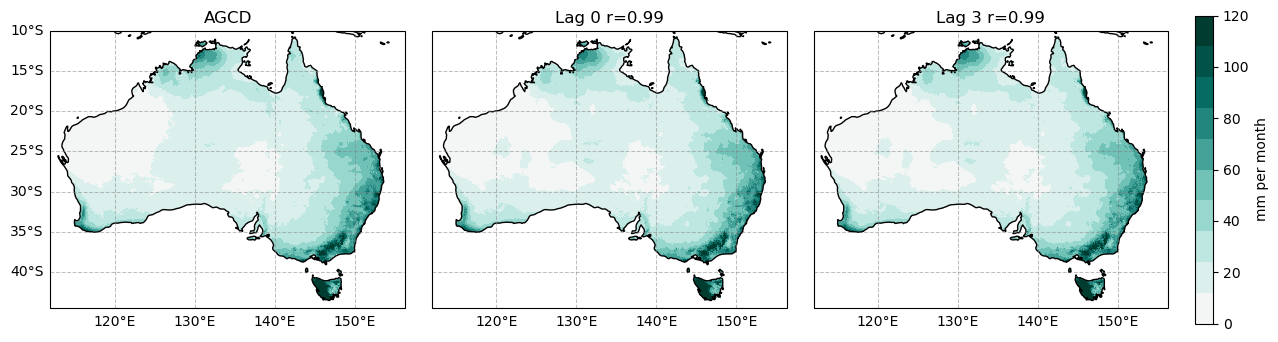

In [62]:
fig = plt.figure(figsize=(15, 4))  
gs = gridspec.GridSpec(1, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
vmin = 0
vmax = 120

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = agcd.mean(dim='year').plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('AGCD')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = precip0_son.mean(dim='year').plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f'Lag 0 r={pc0:.2f}')
ax = format_gridlines(ax, bottom_labels=True)

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = precip3_son.mean(dim='year').plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f'Lag 3 r={pc3:.2f}')
ax = format_gridlines(ax, bottom_labels=True)

# First colorbar for precip
cax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('mm per month');

#### Correlation through time

In [17]:
corr_map0 = func.corr_along_time(agcd.chunk({'year':-1}), precip0_son)
corr_map3 = func.corr_along_time(agcd.chunk({'year':-1}), precip3_son)
corr_map9 = func.corr_along_time(agcd.chunk({'year':-1}), precip9_son)

In [18]:
p_map0 = func.corr_along_time(agcd.chunk({'year':-1}), precip0_son, 1)
p_map3 = func.corr_along_time(agcd.chunk({'year':-1}), precip3_son, 1)
p_map9 = func.corr_along_time(agcd.chunk({'year':-1}), precip9_son, 1)

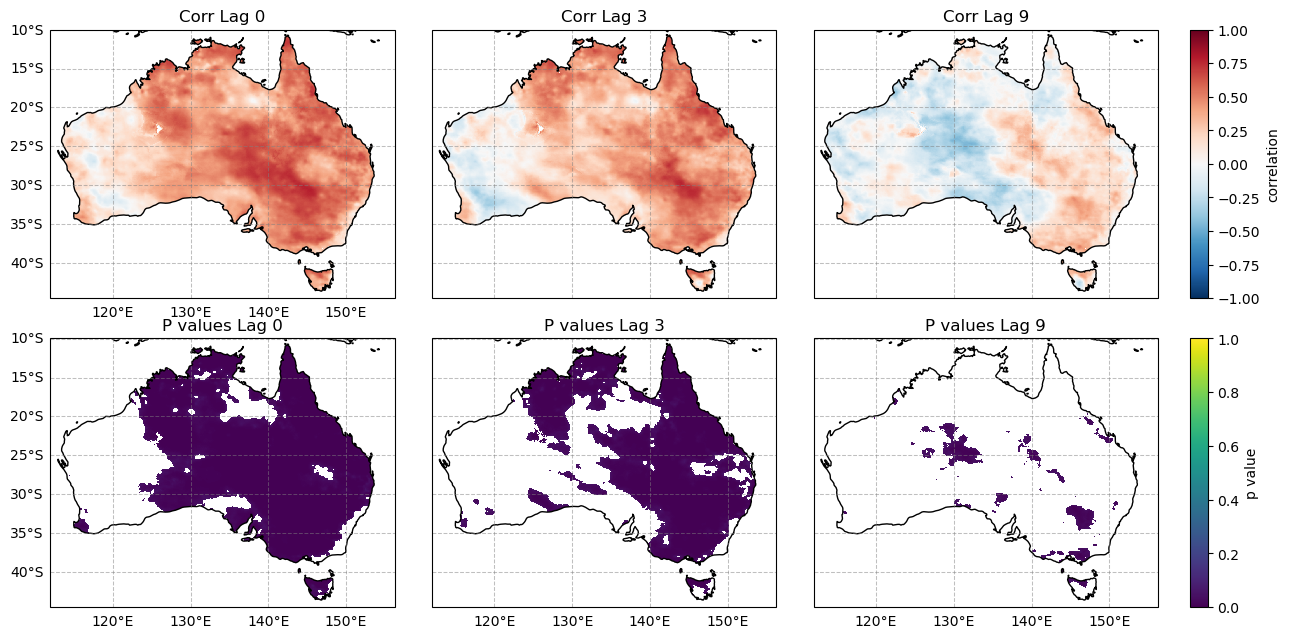

In [19]:
fig = plt.figure(figsize=(15, 7.5))  
gs = gridspec.GridSpec(2, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
vmin = -1
vmax = 1
cmap = 'RdBu_r'

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = corr_map0.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Corr Lag 0')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = corr_map3.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Corr Lag 3')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = corr_map9.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Corr Lag 9')
ax = format_gridlines(ax)

# First colorbar for correlation
cax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('correlation');

vmin = 0
vmax = 1
cmap = 'viridis'

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = p_map0.where(p_map0<0.05).plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('P values Lag 0')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = p_map3.where(p_map3<0.05).plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('P values Lag 3')
ax = format_gridlines(ax, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
im = p_map9.where(p_map9<0.05).plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('P values Lag 9')
ax = format_gridlines(ax, bottom_labels=True) 

# Second colorbar for p vals
cax = plt.subplot(gs[1, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('p value');

In [20]:
# Correlations over Murry Darling Basin Region
mdba = agcd.sel(lat=slice(-34,-22)).sel(lon=slice(139,149)).mean(dim=['lat','lon'])
mdb0 = son_lag0_yearly.sel(lat=slice(-34,-22)).sel(lon=slice(139,149)).mean(dim=['lat','lon'])
mdb3 = son_lag3_yearly.sel(lat=slice(-34,-22)).sel(lon=slice(139,149)).mean(dim=['lat','lon'])
mdb9 = son_lag9_yearly.sel(lat=slice(-34,-22)).sel(lon=slice(139,149)).mean(dim=['lat','lon'])

In [21]:
cors0 = []
for ens in mdb0.ensemble:
    cors0.append(pearsonr(mdba, mdb0.sel(ensemble=ens))[0])

In [22]:
cors3 = []
for ens in mdb3.ensemble:
    cors3.append(pearsonr(mdba, mdb3.sel(ensemble=ens))[0])

In [23]:
cors9 = []
for ens in mdb9.ensemble:
    cors9.append(pearsonr(mdba, mdb9.sel(ensemble=ens))[0])

<Axes: >

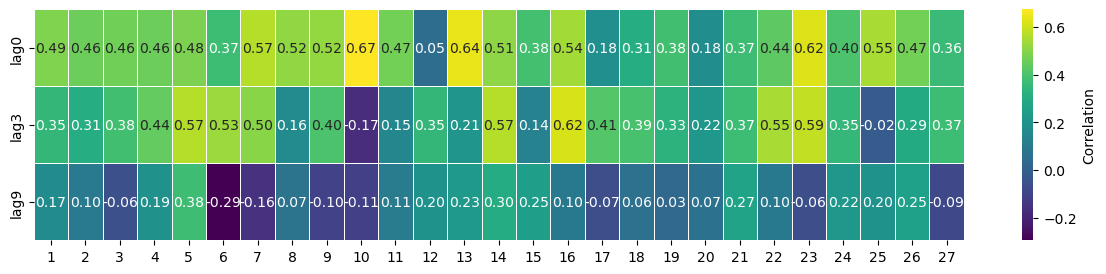

In [25]:
data = np.array([cors0, cors3, cors9])
plt.figure(figsize=(15, 3))  
sns.heatmap(data, annot=True, fmt=".2f", cmap="viridis", cbar=True, 
            xticklabels=np.arange(1, 28), yticklabels=["lag0", "lag3", "lag9"], 
            cbar_kws={'label': 'Correlation'}, linewidths=0.5)

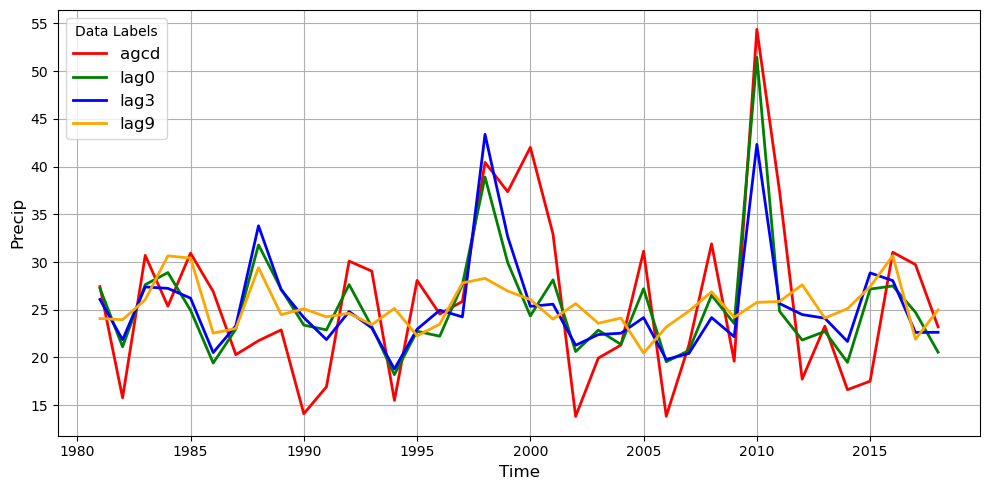

In [26]:
plt.figure(figsize=(10, 5))

# Plot each data array with appropriate labels
agcd.mean(dim=['lat', 'lon']).plot(label='agcd', color='red', linewidth=2)
precip0_son.mean(dim=['lat', 'lon']).plot(label='lag0', color='green', linewidth=2)
precip3_son.mean(dim=['lat', 'lon']).plot(label='lag3', color='blue', linewidth=2)
precip9_son.mean(dim=['lat', 'lon']).plot(label='lag9', color='orange', linewidth=2)

# Customize the plot
plt.xlabel("Time", fontsize=12)
plt.ylabel("Precip", fontsize=12)
plt.legend(title='Data Labels', loc='upper left', fontsize=12)

# Show the plot
plt.grid(True)
plt.tight_layout()

#### Compare with Mandy's data 

In [39]:
precip0_m = xr.open_dataset('maq5_pr_19810101-20181231_ENSEMBLE_0_Aus_Ensmean.nc').pr
precip3_m = xr.open_dataset('maq5_pr_19810101-20181231_ENSEMBLE_3_Aus_Ensmean.nc').pr

precip0_son_m = precip0_m.sel(time=precip0_m.time.dt.season == "SON").groupby("time.year").mean("time") #.where(landmask.data==1).persist()
precip0_son_m = precip0_son_m * 30.33

precip3_son_m = precip3_m.sel(time=precip3_m.time.dt.season == "SON").groupby("time.year").mean("time") #.where(landmask.data==1).persist()
precip3_son_m = precip3_son_m * 30.33

In [34]:
# Regrid AGCD
ds_bnds = precip.to_dataset().cf.add_bounds(['lat','lon'])
sample_bnds = precip0_m.to_dataset().cf.add_bounds(['lat','lon'])

regrid = xesmf.Regridder(ds_bnds, sample_bnds, method='conservative_normed')

landmask_regrid = regrid(landmask)
agcd_regrid = regrid(son_yearly)

agcd_regrid = agcd_regrid.sel(year=precip0_son_m.year)

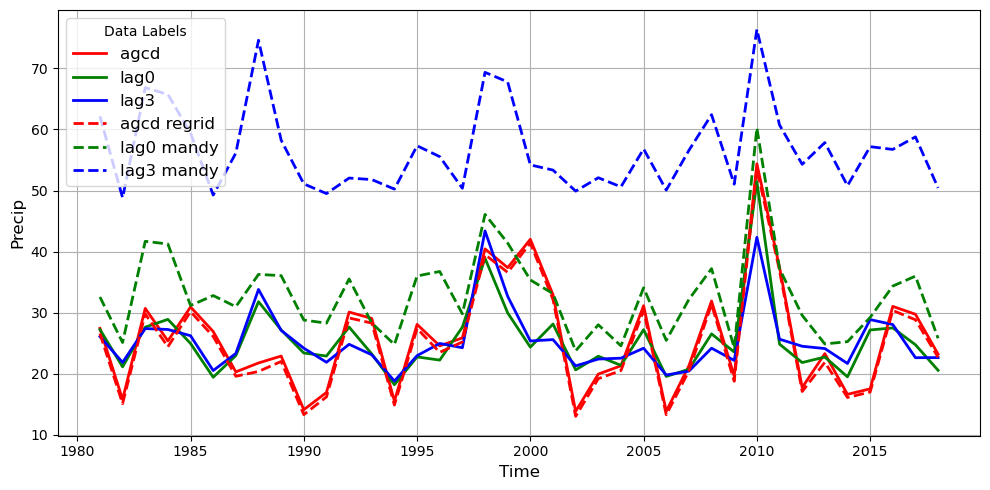

In [72]:
plt.figure(figsize=(10, 5))

# Plot each data array with appropriate labels
agcd.mean(dim=['lat', 'lon']).plot(label='agcd', color='red', linewidth=2)
precip0_son.mean(dim=['lat', 'lon']).plot(label='lag0', color='green', linewidth=2)
precip3_son.mean(dim=['lat', 'lon']).plot(label='lag3', color='blue', linewidth=2)

agcd_regrid.mean(dim=['lat', 'lon']).plot(label='agcd regrid', color='red', linestyle='--', linewidth=2)
precip0_son_m.mean(dim=['lat', 'lon']).plot(label='lag0 mandy', color='green', linestyle='--', linewidth=2)
precip3_son_m.mean(dim=['lat', 'lon']).plot(label='lag3 mandy', color='blue', linestyle='--', linewidth=2)

# Customize the plot
plt.xlabel("Time", fontsize=12)
plt.ylabel("Precip", fontsize=12)
plt.legend(title='Data Labels', loc='upper left', fontsize=12)

# Show the plot
plt.grid(True)
plt.tight_layout()

In [73]:
client.close()

In [5]:
import os
sys.stderr=open(os.devnull,'w')